In [1]:
import numpy as np
import autograd.numpy as anp  # Thinly-wrapped numpy
import pandas as pd
import scipy as sp
# import pymc3 as pm
# import arviz as az
# import theano as th
# import theano.tensor as tt
# import warnings
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import optimize
# from pymc3.gp.util import plot_gp_dist
from autograd import grad     # The only autograd function you may ever need
from autograd import elementwise_grad as egrad

from plotutils import addtxt
# warnings.simplefilter(action='ignore', category=FutureWarning)
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

In [2]:
def K_SquareExp(x1,x2,l=1.0):
    return np.exp(-0.5*(np.subtract.outer(x1,x2)/l)**2)

def GP(μ, K, noise): # Rasmussen pg. 201
    return np.random.multivariate_normal(μ, K + np.diag(noise))

def GPfast(μ, K, noise): # Rasmussen pg. 201
    L = np.linalg.cholesky(K + np.diag(noise)) # adding small noise makes calculation more stable
    u = np.random.randn(len(μ))
    return μ + np.dot(L, u)

def GPpost0(x_obs, y_obs, x_new, μ, K_obs_obs, K_new_obs, K_new_new): # Rasmussen pg. 16
    # return posterior distribution for test data at x* (y*), conditioned on training data at x (y)
    # p(y* | y, x) = GP(μ(x*) + (K*)^t K \ δy, K** - (K*)^t K \ K*) 
    L = np.linalg.cholesky(K_obs_obs)

    # α = K \ δy(x) = L^t \ (L | δy)
    α = np.linalg.solve(L.transpose(), np.linalg.solve(L, y_obs - μ(x_obs)))

    # μpost = μ(x*) + (K*)^t K \ δy(x)
    μpost = μ(x_new) + np.dot(K_new_obs, α) # posterior avg
    
    # Kpost = K** - (K*)^t K | K* = K** - W
    # W_ij  = v_i . v_j 
    # v_i   = (L | c_i) . (L | c_j); c_i the i-th column of K*, i-th row of (K*)^t
    V     = np.array([np.linalg.solve(L, c) for c in K_new_obs]) # V= [v_1, v_2, ...]^t
    Kpost = K_new_new - np.einsum('ik,jk->ij', V, V)
    return μpost, Kpost

def GPpost(x_obs, y_obs, x_new, μ, K, noise_obs): # Rasmussen pg. 16
    # return posterior distribution for test data at x* (y*), conditioned on training data at x (y)
    # p(y* | y, x) = GP(μ(x*) + (K*)^t K \ δy, K** - (K*)^t K \ K*) 
    K_obs_obs  = K(x_obs, x_obs) + np.diag(noise_obs) # K
    K_new_new  = K(x_new, x_new) # K**
    K_new_obs  = K(x_new, x_obs) # (K*)^t
    return GPpost0(x_obs, y_obs, x_new, μ, K_obs_obs, K_new_obs, K_new_new)

In [3]:
derivative = lambda func,x: egrad(func)(x)
def tangent(f,x0):
    m = grad(f)(x0)
    b = f(x0) - m*x0
    return lambda z: m*z + b

In [4]:
def f(x):
    return 1e-3*(x+5)*(x-2)*(x-7)*(x+0.4)*(x-1.5)

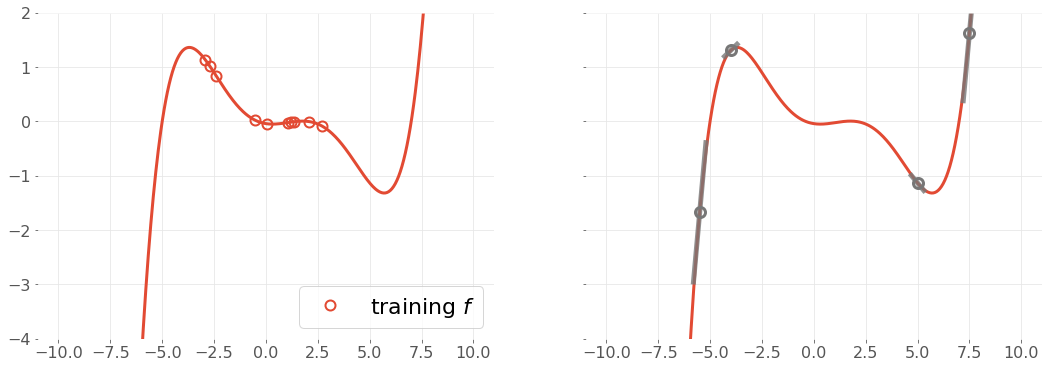

In [5]:
np.random.seed(666)
a,b= -6,6
xt = (a + np.random.rand(10)*(b-a)*0.5) + (b-a)*0.25    # training data on function
xs = np.array([-5.5, -4, 5, 7.5])                       # training data on derivative
nums = {'obs':len(xt) + len(xs), 'new':500}


fig, [ax,bx] = plt.subplots(figsize=(18,6), ncols=2, sharex=True, sharey=True)
x  = np.linspace(-10,10,num=nums['new'])
# function
ax.plot(x, f(x))
ax.plot(xt, f(xt), marker='o', mfc='None', ls='None', mew=2, color="C0", label=r'training $f$')

# derivative
bx.plot(x,f(x))
bx.plot(xs, f(xs), marker='o', mfc='None', ls='None', mew=3, color="C3", label=r'training $f^\prime$')
for x0 in xs:
    fprime = tangent(f,x0)
    dx     = np.linspace(x0-0.3, x0+0.3)
    bx.plot(dx,fprime(dx), color="C3",lw=5,alpha=0.8)
ax.set_ylim(-4,2)
ax.legend(fontsize=22)
plt.show()

Recall that the posterior for the hyperparameters is of the form
\begin{align}
\log{P(\eta,l | D, I)} &= -\frac{1}{2}\left[y^t K^{-1}(\eta, l) y + \log{\det{K(\eta,l)}} + n \log(2\pi)\right] 
- \left[\log{l} + \log{\eta}\right]
\end{align}
where we have assumed that $\pi(\theta) = \pi(l, \eta)= \pi(l) \pi(\eta)$ and $\mu = 0$. Maximizing this expression, gives the optimal $\eta$ and $l$ values
for our Kernel.

In [6]:
# https://mmas.github.io/optimization-scipy
def gethyperparams(x, y, noise, K):
    def logGP(*,η,l):
        L = η*np.linalg.cholesky(K(x,x,l=l) + np.diag(noise))
        v = np.linalg.solve(L, y)
        return 0.5*np.dot(v,v) + np.sum(np.log(np.diag(L))) # 1/2 [ y K \ y + log|K|]
    
    logp = lambda p: (logGP(η = p[0], l = p[1]) + np.log(p[0]) + np.log(p[1])) # - log P(η, l | D)
    opt0 = optimize.minimize(logp, [1, 1], method='Nelder-Mead', options={'maxiter':2000, 'disp':0}) # downhill simplex
    return opt0
opts = gethyperparams(xt, f(xt), np.ones_like(xt)*1e-12, K_SquareExp)
for o in [opts]:
    print(f'\t chi2 = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    print(f'\t\t η = {o["x"][0]:6.3f}, l = {o["x"][1]:6.3f}')

	 chi2 = -3.375230e+01, niter =    44, Converged =      1 : Optimization terminated successfully.
		 η =  0.693, l =  2.013


In [7]:
ηopt, lopt = opts['x']
μopt, Kopt = GPpost(xt, f(xt), x, lambda x : 0.0, lambda x,y:ηopt**2*K_SquareExp(x,y,l=lopt), np.ones_like(xt)*1e-12)
σopt       = np.sqrt(np.diag(Kopt))
ytest      = np.array([GPfast(μopt, Kopt, np.ones_like(x)*1e-12) for i in range(100)])

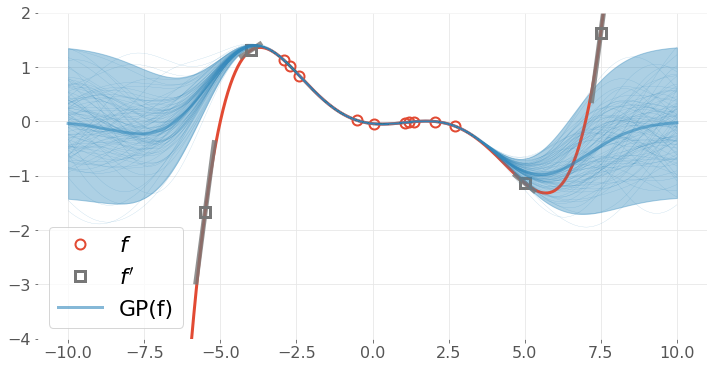

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, f(x))
ax.plot(xt, f(xt), marker='o', mfc='None', ls='None', mew=2, color="C0", label='$f$')
ax.plot(xs, f(xs), marker='s', mfc='None', ls='None', mew=3, color="C3", label='$f^\prime$')
for x0 in xs:
    fprime = tangent(f,x0)
    dx     = np.linspace(x0-0.3, x0+0.3)
    ax.plot(dx,fprime(dx), color="C3",lw=5,alpha=0.8)


l, = ax.plot(x, μopt, alpha=0.6, label='GP(f)')
ax.fill_between(x, μopt - 2*σopt, μopt + 2*σopt, color=l.get_color(), alpha=0.4) # avg+/-2sigma
for y in ytest:
    ax.plot(x, y, lw=0.2, color=l.get_color(), alpha=0.5)
    
ax.set_ylim(-4,2)
ax.legend(fontsize=22)
plt.show()

Now, let's see what happens when we include information on the derivatives ($y^\prime$).
\begin{align}
\begin{pmatrix}
y \\
y^\prime \\
y^\star
\end{pmatrix}\sim\mathcal{N}\left(0, \begin{pmatrix}
K_{yy} & K_{y y^\prime} & K_{y y^\star} \\
K_{y^\prime y} & K_{y^\prime y^\prime} & K_{y^\prime y^\star} \\
K_{y^\star y} & K_{y^\star y^\prime} &K_{y^\star y^\star}
\end{pmatrix}\right)
\end{align}

Recall that training datay are composed now of $y$ (defined on $x$) and $y^\prime$ (defined on $x^\prime$), and that the test data $y^\star$ is defined on $x^\star$.
Let us group the training set into a super set, such that $\widetilde{x} = (x, x^\prime)$

\begin{align}
y^\star \lvert y,y^\prime \sim \mathcal{N}\left( \Sigma_\star \Sigma^{-1} \begin{pmatrix}y\\y^\prime\end{pmatrix} ,
\Sigma_{\star\star} - \Sigma_\star \Sigma^{-1} \Sigma_\star^t\right)
\end{align}

\begin{align}
\Sigma(\widetilde{x}, \widetilde{x}) &= \begin{pmatrix}K_{yy}(x,x) & K_{yy^\prime}(x,x^\prime) \\ K_{y^\prime y}(x^\prime,x) & K_{y^\prime y^\prime}(x^\prime,x^\prime)\end{pmatrix}\\
\Sigma_\star(x^\star, \widetilde{x}) &= \begin{pmatrix}K_{y^\star y}(x^\star, x) K_{y^\star y^\prime}(x^\star, x^\prime)\end{pmatrix} \\
\Sigma_{\star\star}(x^\star, x^\star) &= K_{y^\star y^\star}(x^\star, x^\star)
\end{align}

Given the linearity of the problem, and the GP properties, we express all covariance kernels in terms of $K_{yy}$

\begin{align}
K_{y y^\prime}(x,x^\prime) &= \left\langle y(x) y^\prime(x^\prime)\right\rangle
= \left\langle y(x) \frac{\partial}{\partial x^\prime} y(x^\prime)\right\rangle \\
&= \frac{\partial}{\partial x^\prime}\left\langle y(x) y(x^\prime)\right\rangle \equiv \frac{\partial}{\partial x^\prime} K_{yy}(x,x^\prime) \\
K_{y^\prime y^\prime}(x_1^\prime, x_2^\prime) &= \left\langle y^\prime(x_1^\prime) y^\prime(x_2^\prime)\right\rangle \equiv \frac{\partial}{\partial x_1^\prime} \frac{\partial}{\partial x_2^\prime} K_{yy}(x_1^\prime, x_2^\prime) \\
K_{y^\star y^\star}(x_1^\star, x_2^\star) &=\left\langle y^\star(x_1^\star) y^\star(x_2^\star)\right\rangle \equiv K_{yy}(x_1^\star, x_2^\star)
\end{align}

\begin{align}
K_{y y^\prime}(x, x^\prime) &= \frac{\eta^2}{l^2}\left(x - x^\prime\right) \exp{\left[-\frac{(x-x^\prime)^2}{2 l^2}\right]} &=& \frac{x - x^\prime}{l^2} K_{yy}(x,x^\prime)\\
K_{y^\prime, y^\prime}(x_1^\prime, x_2^\prime) &= \frac{\eta^2}{l^2}\left(1 - \frac{(x_1^\prime - x_2^\prime)^2}{l^2}\right) \exp{\left[-\frac{\left(x_1^\prime - x_2^\prime\right)^2}{2l^2}\right]} &=& \frac{1}{l^2}\left(1 - \frac{\left(x_1^\prime - x_2^\prime\right)^2}{l^2}\right) K_{yy}(x_1^\prime, x_2^\prime)
\end{align}

We can learn the hyperparameters $(\eta, l)$ by maximizing the posterior, but now

\begin{align}
\log{P(\eta,l | D, I)} &= -\frac{1}{2}\left[\begin{pmatrix}y &y^\prime\end{pmatrix} K_{yy^\prime}^{-1}(\eta, l) \begin{pmatrix}y\\ y^\prime\end{pmatrix} + \log{\det{K_{yy^\prime}(\eta,l)}} \right] 
- \left[\log{l} + \log{\eta}\right] + \text{const}
\end{align}

In [9]:
def getK_obs_obs(Koo, xo_f, xo_df, l = 1.0):
    n = len(xo_f)
    Koo[:n, :n] = K_SquareExp(xo_f, xo_f, l)
    Koo[:n, n:] = 1./l**2*np.subtract.outer(xo_f, xo_df)*K_SquareExp(xo_f, xo_df, l)
    Koo[n:, :n] = np.transpose(Koo[:n, n:])
    Koo[n:, n:] = 1./l**2*(1.-np.subtract.outer(xo_df, xo_df)**2/l**2)*K_SquareExp(xo_df, xo_df, l)
    return Koo

def getK_new_obs(Kno, xo_f, xo_df, xn, l = 1.0):
    n = len(xo_f)
    Kno[:, :n] = K_SquareExp(xn, xo_f, l)
    Kno[:, n:] = 1./l**2*np.subtract.outer(xn, xo_df)*K_SquareExp(xn, xo_df, l)
    return Kno

def getK_new_new(Knn, xn, l=1.0):
    Knn[:, :] = K_SquareExp(xn, xn, l)
    return Knn

def gethyperparams2(x_f, x_df, f, df, noise):
    n = len(x_f) + len(x_df)
    K = np.zeros((n,n))
    y = np.concatenate([f,df])
    def logGP(*,η,l):
        K[...] = getK_obs_obs(K, x_f, x_df, l)
        L = η*np.linalg.cholesky(K + np.diag(noise))
        v = np.linalg.solve(L, y)
        return 0.5*np.dot(v, v) + np.sum(np.log(np.diag(L)))
    
    logp = lambda p: (logGP(η = p[0], l = p[1]) + np.log(p[0]) + np.log(p[1])) # - log P(η, l | D)
    opt0 = optimize.minimize(logp, [1, 1], method='Nelder-Mead', options={'maxiter':2000, 'disp':0}) # downhill simplex
    return opt0

opts2 = gethyperparams2(xt, xs, f(xt), derivative(f, xs), np.concatenate([np.ones_like(xt), np.ones_like(xs)*1.e2])*1.e-8)
for o in [opts2]:
    print(f'\t chi2 = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    print(f'\t\t η = {o["x"][0]:6.3f}, l = {o["x"][1]:6.3f}')

	 chi2 = -1.027221e+01, niter =    68, Converged =      1 : Optimization terminated successfully.
		 η =  8.266, l =  2.664


In [10]:
ηopt2, lopt2 = opts2['x']
K_obs_obs    = np.zeros((nums['obs'], nums['obs']))
K_new_obs    = np.zeros((nums['new'], nums['obs']))
K_new_new    = np.zeros((nums['new'], nums['new']))

K_obs_obs[...] = ηopt2**2*getK_obs_obs(K_obs_obs, xt, xs, lopt2) \
                        + np.diag(np.concatenate([np.ones_like(xt), np.ones_like(xs)*1.e2])*1.e-8)
K_new_obs[...] = ηopt2**2*getK_new_obs(K_new_obs, xt, xs, x, lopt2)
K_new_new[...] = ηopt2**2*getK_new_new(K_new_new, x, lopt2)

μopt2, Kopt2 = GPpost0(np.concatenate([xt, xs]), np.concatenate([f(xt),derivative(f, xs)]), \
                       x, lambda x : 0., K_obs_obs, K_new_obs, K_new_new)
σopt2        = np.sqrt(np.diag(Kopt2))
ytest2       = np.array([GPfast(µopt2, Kopt2, np.ones_like(x)*1.e-12) for i in range(100)])

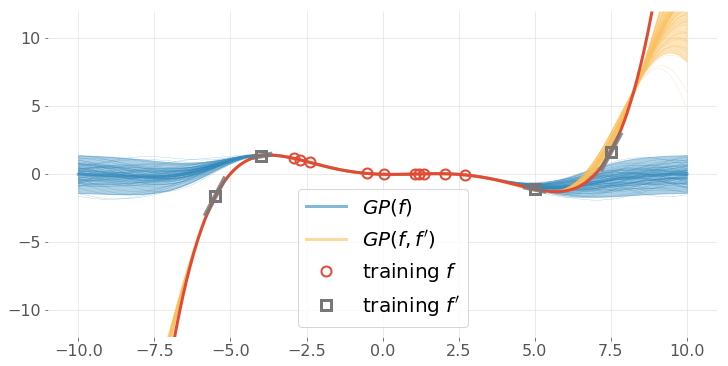

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

l, = ax.plot(x, μopt, alpha=0.6, label=r'$GP(f)$', color='C1')
ax.fill_between(x, μopt - 2*σopt, μopt + 2*σopt, color=l.get_color(), alpha=0.4) # avg+/-2sigma
for y in ytest:
    ax.plot(x, y, lw=0.2, color=l.get_color(), alpha=0.8)
    
l, = ax.plot(x, μopt2, alpha=0.6, label=r'$GP(f,f^\prime)$', color='C4')
ax.fill_between(x, μopt2 - 2*σopt2, μopt2 + 2*σopt2, color=l.get_color(), alpha=0.4) # avg+/-2sigma
for y in ytest2:
    ax.plot(x, y, lw=0.2, color=l.get_color(), alpha=0.8)
    
ax.plot(x, f(x), color='C0')
ax.plot(xt, f(xt), marker='o', mfc='None', ls='None', mew=2, color="C0", label=r'training $f$')
ax.plot(xs, f(xs), marker='s', mfc='None', ls='None', mew=3, color="C3", label=r'training $f^\prime$')
for x0 in xs:
    fprime = tangent(f,x0)
    dx     = np.linspace(x0-0.3, x0+0.3)
    ax.plot(dx,fprime(dx), color="C3",lw=5,alpha=0.8)
    
ax.set_ylim(-12,12)
ax.legend(fontsize=20)
plt.show()